# On-off control
Here we will see how to set up a minimum, working closed loop with a very simple threshold-triggered control scheme.

Preamble:

In [1]:
from brian2 import *
from cleo import *

import matplotlib.pyplot as plt

utilities.style_plots_for_docs()

# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"

## Set up network
We will use a simple leaky integrate-and-fire network with Poisson spike train input. We use Brian's standard `SpikeMonitor` to view resulting spikes here for simplicity, but see the electrodes tutorial for a more realistic electrode recording scheme.

In [2]:
n = 10
population = NeuronGroup(n, '''
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(n, np.linspace(0, 100, n)*Hz + 10*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition='abs(i-j)<=3')

pop_mon = SpikeMonitor(population)

net = Network([population, input_group,S, pop_mon])

print("Recorded population's equations:")
population.user_equations

Recorded population's equations:


dv/dt = (I*Rm - 70*mV - v)/tau : volt
tau : second
Rm : ohm
I : amp


## Run simulation

In [3]:
net.run(200*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]


[Text(0.5, 1.0, 'population spiking'),
 Text(0, 0.5, 'neuron index'),
 Text(0.5, 0, 'time (ms)')]

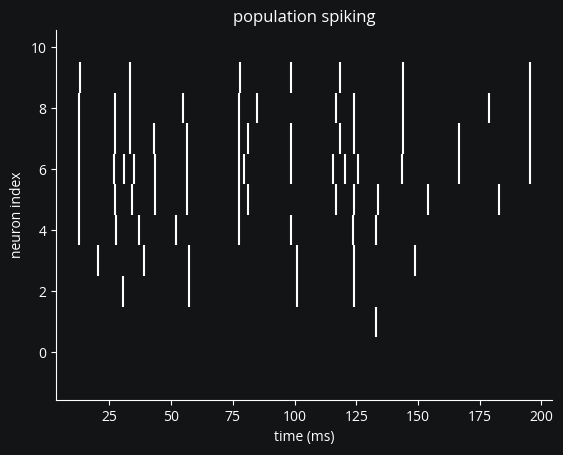

In [4]:
sptrains = pop_mon.spike_trains()
fig, ax = plt.subplots()
ax.eventplot([t / ms for t in sptrains.values()], lineoffsets=list(sptrains.keys()))
ax.set(title='population spiking', ylabel='neuron index', xlabel='time (ms)')

Because lower neuron indices receive very little input, we see no spikes for neuron 0. Let's change that with closed-loop control.

## IO processor setup
We use the `IOProcessor` class to define interactions with the network.
To achieve our goal of making neuron 0 fire, we'll use a contrived, simplistic setup where
1.  the recorder reports the voltage of a given neuron (of index 5 in our case),
2.  the controller outputs a pulse whenever that voltage is below a certain threshold, and
3.  the stimulator applies that pulse to the specified neuron. 

So if everything is wired correctly, we'll see bursts of activity in just the first neuron.

In [5]:
from cleo.recorders import RateRecorder, VoltageRecorder
from cleo.stimulators import StateVariableSetter

i_rec = int(n / 2)
i_ctrl = 0
sim = CLSimulator(net)
v_rec = VoltageRecorder(name="rec")
sim.inject(v_rec, population[i_rec])
sim.inject(
    StateVariableSetter(name="stim", variable_to_ctrl="I", unit=nA), population[i_ctrl]
)

CLSimulator(io_processor=None, devices={VoltageRecorder(brian_objects={<StateMonitor, recording ['v'] from 'neurongroup_subgroup'>}, sim=..., name='rec', voltage_var_name='v', mon=<StateMonitor, recording ['v'] from 'neurongroup_subgroup'>), StateVariableSetter(brian_objects=set(), sim=..., name='stim', value=0, default_value=0, save_history=True, variable_to_ctrl='I', unit=namp, neuron_groups=[<Subgroup 'neurongroup_subgroup_1' of 'neurongroup' from 0 to 1>])})

We need to implement the `LatencyIOProcessor` object. For a more sophisticated case we'd use `ProcessingBlock` objects to decompose 
the computation in the `process` function.

In [6]:
from cleo.ioproc import LatencyIOProcessor

trigger_threshold = -60*mV
class ReactivePulseIOProcessor(LatencyIOProcessor):
    def __init__(self, pulse_current=1):
        super().__init__(sample_period_ms=1)
        self.pulse_current = pulse_current
        self.out = {}

    def process(self, state_dict, time_ms):
        v = state_dict['rec']
        if v is not None and v < trigger_threshold:
            self.out['stim'] = self.pulse_current
        else:
            self.out['stim'] = 0

        return (self.out, time_ms)

sim.set_io_processor(ReactivePulseIOProcessor(pulse_current=1))

CLSimulator(io_processor=<__main__.ReactivePulseIOProcessor object at 0x7f57975a1600>, devices={VoltageRecorder(brian_objects={<StateMonitor, recording ['v'] from 'neurongroup_subgroup'>}, sim=..., name='rec', voltage_var_name='v', mon=<StateMonitor, recording ['v'] from 'neurongroup_subgroup'>), StateVariableSetter(brian_objects=set(), sim=..., name='stim', value=0, default_value=0, save_history=True, variable_to_ctrl='I', unit=namp, neuron_groups=[<Subgroup 'neurongroup_subgroup_1' of 'neurongroup' from 0 to 1>])})

And run the simulation:

In [7]:
sim.run(200*ms)

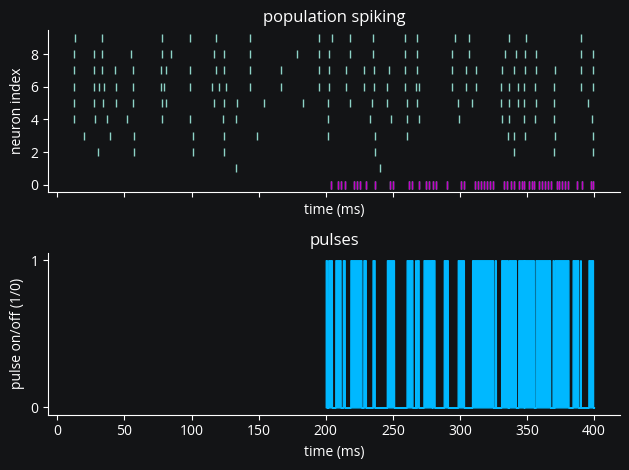

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(pop_mon.t / ms, pop_mon.i[:], "|")
ax1.plot(
    pop_mon.t[pop_mon.i == i_ctrl] / ms,
    pop_mon.i[pop_mon.i == i_ctrl],
    "|",
    c="#C500CC",
)
ax1.set(title="population spiking", ylabel="neuron index", xlabel="time (ms)")
ax2.fill_between(
    v_rec.mon.t / ms, (v_rec.mon.v.T < trigger_threshold)[:, 0], color=(0.0, 0.72, 1.0)
)
ax2.set(title="pulses", xlabel="time (ms)", ylabel="pulse on/off (1/0)", yticks=[0, 1])
plt.tight_layout()

Yes, we see the IO processor triggering pulses as expected.
And here's a plot of neuron 5's voltage to confirm that those pulses
are indeed where we expect them to be, whenever the voltage is
below -60 mV.

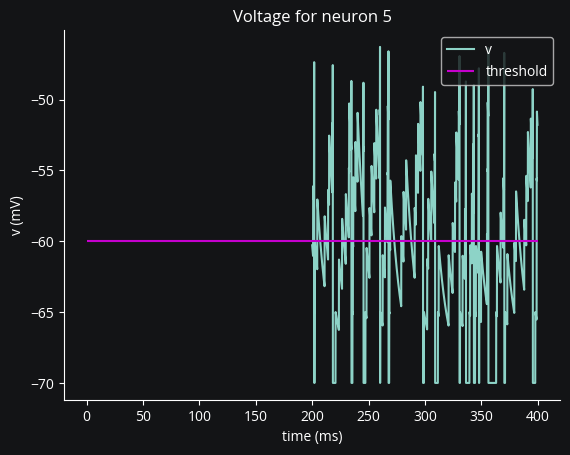

In [9]:
fig, ax = plt.subplots()
ax.set(title=f"Voltage for neuron {i_rec}", ylabel="v (mV)", xlabel='time (ms)')
ax.plot(v_rec.mon.t/ms, v_rec.mon.v.T / mV);
ax.hlines(-60, 0, 400, color='#c500cc');
ax.legend(['v', 'threshold'], loc='upper right');

## Conclusion
In this tutorial we've seen the basics of configuring an `IOProcessor` to implement a closed-loop intervention on a Brian network simulation.